# Prepare PPI Network
In this notebook, I want to collect the protein-protein-interaction (PPI) network from ConsensusPathDB and preprocess it.
The preprocessing contains the following steps:
* Filter out "complex" interactions (more than two partners)
* Filter out interactions with score < 0.5
* Map the strange uniprot gene names to ENSEMBL IDs (either protein IDs or gene IDs)
* Convert the resulting edgelist to an adjacency matrix
* Export the edgelist to .sif (can be read by cytoscape directly)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mygene
import h5py
import networkx as nx
import seaborn as sns
%matplotlib inline

In [2]:
def save_sif(edgelist, outfile):
    print ("Saving edgelist to {}".format(outfile))
    with open(outfile, 'w') as out:
        for idx, row in edgelist.iterrows():
            out.write('{} (interacts) {}\n'.format(row.partner1, row.partner2))
    print (".sif successfully saved!")


def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_gene_symbols_from_proteins(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.protein',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

## Preprocess CPDB
Now I want to load all the interactions and build an edgelist from them. Once I have that edgelist, I can construct an adjacency matrix from it.

In [3]:
interactions = pd.read_csv('../../../data/networks/ConsensusPathDB_human_PPI.29012019.gz',
                                     compression='gzip',
                                     header=1,
                                     sep='\t',
                                     encoding='utf8'
                                    )
interactions_nona = interactions.dropna()
interactions_nona.head()

,# source_databases,interaction_publications,interaction_participants,interaction_confidence
8,"Reactome,Biogrid,Spike,HPRD,PhosphoPOINT","1660465,16713569,12547834","ANF_HUMAN,ANPRA_HUMAN",0.342234
9,"PhosphoPOINT,HPRD,Reactome,Biogrid","1660465,12709393,1672777,1309330","ANPRB_HUMAN,ANFC_HUMAN",0.119181
24,"DIP,Reactome,IntAct","22210847,17486119,21408196,16906149,19897728","STIM1_HUMAN,TRPC1_HUMAN",0.998166
25,"Reactome,HPRD",11591728,"NOS1_HUMAN,AT2B4_HUMAN",0.694108
26,"CORUM,HPRD,BIND,Reactome,IntAct,MIPS-MPPI","10093054,9831708,23587463","ABCC9_HUMAN,KCJ11_HUMAN",0.999997


(372507, 4)

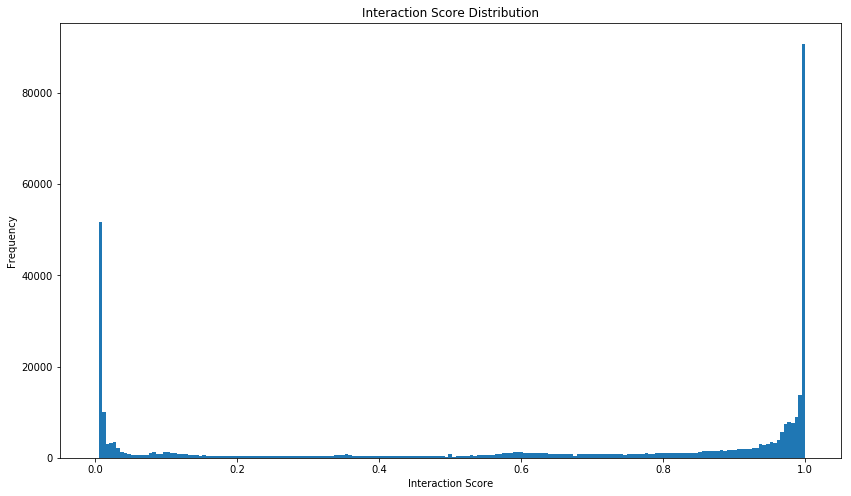

In [4]:
bins = np.linspace(0, 1, 200)
fig = plt.figure(figsize=(14, 8))
ax = plt.hist(interactions_nona.interaction_confidence, bins)
plt.xlabel('Interaction Score')
plt.ylabel('Frequency')
plt.title('Interaction Score Distribution')
interactions_nona.shape

### Remove "complex" interactions & low confidence

In [5]:
# select interactions with exactly two partners
binary_inter = interactions_nona[interactions_nona.interaction_participants.str.count(',') == 1]
# split the interactions columns into interaction partners
edgelist = pd.concat([binary_inter.interaction_participants.str.split(',', expand=True),
                                binary_inter.interaction_confidence], axis=1
                              )
# make the dataframe beautiful
edgelist.set_index([np.arange(edgelist.shape[0])], inplace=True)
edgelist.columns = ['partner1', 'partner2', 'confidence']
edgelist.to_csv('../../../data/networks/CPDB_uni_edgelist.tsv', sep='\t')

# select interactions with confidence score above threshold
high_conf_edgelist = edgelist[edgelist.confidence > .5]

edgelist.head()

,partner1,partner2,confidence
0,ANF_HUMAN,ANPRA_HUMAN,0.342234
1,ANPRB_HUMAN,ANFC_HUMAN,0.119181
2,STIM1_HUMAN,TRPC1_HUMAN,0.998166
3,NOS1_HUMAN,AT2B4_HUMAN,0.694108
4,ABCC9_HUMAN,KCJ11_HUMAN,0.999997


In [7]:
interactions.shape, interactions_nona.shape, edgelist.shape, high_conf_edgelist.shape

((397053, 4), (372507, 4), (372507, 3), (247746, 3))

### Map from Uniprot Name to Ensembl ID
This is not simple at all. We have to write both columns with the interaction partners to file and then use the uniprot webservice (http://www.uniprot.org/mapping/) to do the mapping. The resulting csv files then have to be read again to form the correct edgelist for us.

In [11]:
# write involved uniprot names to file
uniprot_names = edgelist.partner1.append(edgelist.partner2).unique()
np.savetxt('../../../data/networks/uniprot_names.txt', uniprot_names, fmt='%s')

In [17]:
# Build a uniprot mapping manually using the webservice :-(
# load the mapped partners
mapping = pd.read_csv('../../../data/networks/uniprot_ensg_mapping.tsv',
                              sep='\t',
                              header=0,
                              names=['ensembl']
                             )

# get them into our dataframe (size increases because of duplicates in mapping)
# that is, one uniprot gene name has multiple ensembl gene names, hence we have to add those interactions
p1_incl = high_conf_edgelist.join(mapping, on='partner1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(mapping, on='partner2', how='inner', rsuffix='_p2')
both_incl.columns = ['partner1', 'partner2', 'confidence', 'partner1_ensembl', 'partner2_ensembl']

# collect statistics on how many interactions we lost
num_unmaps = both_incl[both_incl.partner1_ensembl.isnull() | both_incl.partner2_ensembl.isnull()].shape[0]
num_p1_unmaps = p1_incl[p1_incl.ensembl.isnull()].partner1.unique().shape[0]
num_p2_unmaps = both_incl[both_incl.partner2_ensembl.isnull()].partner2.unique().shape[0]
print ("We were unable to map {} source and {} target genes.".format(num_p1_unmaps, num_p2_unmaps))
print ("We lost {} interactions this way.".format(num_unmaps))

# kick out the NaNs and remove uniprot names (hate them)
final_edgelist = both_incl.dropna(axis=0)
final_edgelist.drop(['partner1', 'partner2'], axis=1, inplace=True)
print ("Final edge list has {} interactions".format(final_edgelist.shape[0]))

# sort by number and put confidence at last and rename columns
final_edgelist.sort_index(inplace=True)
cols = final_edgelist.columns.tolist()
cols = cols[1:] + [cols[0]]
final_edgelist = final_edgelist[cols]
final_edgelist.columns = ['partner1', 'partner2', 'confidence']

# write to file and look at the first rows
final_edgelist.to_csv('../../../data/networks/CPDB_ensg_edgelist.tsv', sep='\t')
save_sif(final_edgelist, '../../../data/networks/CPDB_ensg_edgelist.sif')
final_edgelist.head()

We were unable to map 0 source and 0 target genes.
We lost 0 interactions this way.
Final edge list has 305196 interactions
Saving edgelist to ../../../data/networks/CPDB_ensg_edgelist.sif
.sif successfully saved!


,partner1,partner2,confidence
2,ENSG00000167323,ENSG00000144935,0.998166
3,ENSG00000089250,ENSG00000058668,0.694108
4,ENSG00000069431,ENSG00000187486,0.999997
5,ENSG00000084754,ENSG00000138029,1.000000
6,ENSG00000197265,ENSG00000153767,0.999969


### Map from Ensembl IDs to Hugo Symbols
Additionally to the edgelists for Uniprot and Ensembl IDs, I also want an edgelist containing the gene names (regular Hugo Symbols).

**I derive it here using the *mygene* webservice**

In [28]:
ens_names = final_edgelist.partner1.append(final_edgelist.partner2).unique()
ens_to_symbol = get_gene_symbols(ens_names)

p1_incl = final_edgelist.join(ens_to_symbol, on='partner1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(ens_to_symbol, on='partner2', how='inner', rsuffix='_p2')
both_incl.columns = ['partner1', 'partner2', 'confidence', 'partner1_symbol', 'partner2_symbol']

# collect statistics on how many interactions we lost
num_unmaps = both_incl[both_incl.partner1_symbol.isnull() | both_incl.partner2_symbol.isnull()].shape[0]
num_p1_unmaps = p1_incl[p1_incl.Symbol.isnull()].partner1.unique().shape[0]
num_p2_unmaps = both_incl[both_incl.partner2_symbol.isnull()].partner2.unique().shape[0]
print ("We were unable to map {} source and {} target genes.".format(num_p1_unmaps, num_p2_unmaps))
print ("We lost {} interactions this way.".format(num_unmaps))

# kick out the NaNs and remove ensembl IDs
final_edgelist_symbols = both_incl.dropna(axis=0)
final_edgelist_symbols.drop(['partner1', 'partner2'], axis=1, inplace=True)
print ("Final edge list has {} interactions".format(final_edgelist_symbols.shape[0]))

# sort by number and put confidence at last and rename columns
final_edgelist_symbols.sort_index(inplace=True)
cols = final_edgelist_symbols.columns.tolist()
cols = cols[1:] + [cols[0]]
final_edgelist_symbols = final_edgelist_symbols[cols]
final_edgelist_symbols.columns = ['partner1', 'partner2', 'confidence']

# remove duplicated interactions (can happen due to multiple Ensembl IDs mapping to the same gene name)
no_interactions = final_edgelist_symbols.shape[0]
final_edgelist_symbols.drop_duplicates(inplace=True)
print ("Dropping {} interactions because the are redundant for gene names".format(no_interactions - final_edgelist_symbols.shape[0]))

# write to file and look at the first rows
final_edgelist_symbols.to_csv('../../../data/networks/CPDB_symbols_edgelist.tsv', sep='\t')
#save_sif(final_edgelist_symbols, '../../../data/networks/CPDB_symbols_edgelist.sif')
final_edgelist_symbols.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-14956...done.
Finished.
We were unable to map 0 source and 0 target genes.
We lost 0 interactions this way.
Final edge list has 305196 interactions
Dropping 52938 interactions because the are redundant for gene names


,partner1,partner2,confidence
2,STIM1,TRPC1,0.998166
3,NOS1,ATP2B4,0.694108
4,ABCC9,KCNJ11,0.999997
5,HADHA,HADHB,1.000000
6,GTF2E2,GTF2E1,0.999969


### Construct Adjacency Matrix

In [29]:
G = nx.from_pandas_edgelist(df=final_edgelist_symbols, source='partner1', target='partner2', edge_attr='confidence')
adj_pd = nx.to_pandas_adjacency(G)
adjacency_matrix = adj_pd.values
node_names = adj_pd.index.values

avg_node_degree = np.mean([value for key, value in G.degree()])
print ("Constructed Adjacency Matrix with average node degree of: {}".format(avg_node_degree))
print ("Adjacency matrix has {} edges and {} nodes in total".format(G.number_of_edges(), G.number_of_nodes()))

Constructed Adjacency Matrix with average node degree of: 37.01313568650473
Adjacency matrix has 252189 edges and 13627 nodes in total


/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Node Degree Distribution of Genes in PPI')

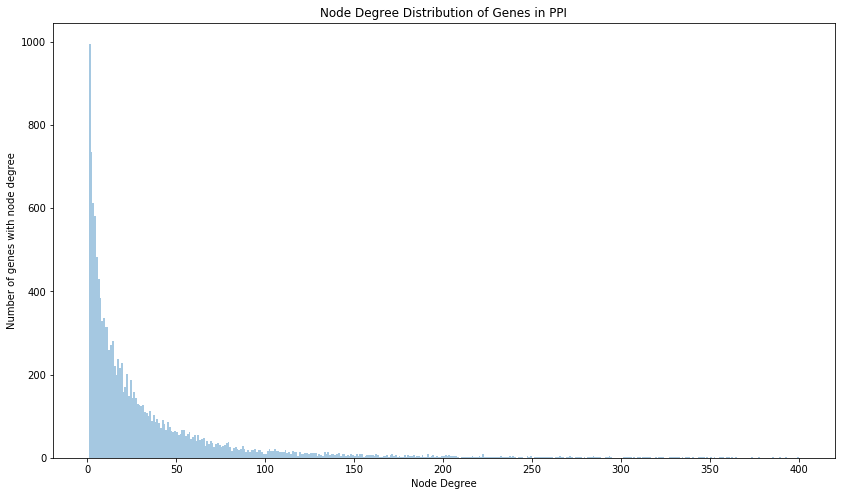

In [30]:
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 400, 400)
sns.distplot(node_degrees, kde=False, bins=bins)

#ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

### Store Adjacency matrix on Disk

In [62]:
f = h5py.File('../../../data/networks/CPDB_ppi_ens.h5', 'w')
f.create_dataset('consensusPathDB_ppi', data=adjacency_matrix, shape=adjacency_matrix.shape)
string_dt = h5py.special_dtype(vlen=str)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
f.close()

## Preprocess STRING DB Network

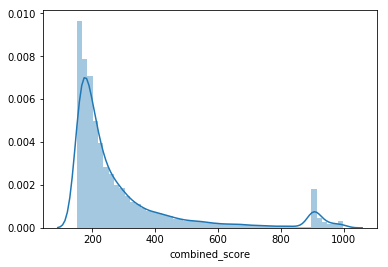

In [3]:
string_ppis = pd.read_csv('../../../data/networks/9606.protein.links.v11.0.txt', sep=' ')
sns.distplot(string_ppis.combined_score, kde_kws={'bw': 20})

In [4]:
high_conf_string_ppis = string_ppis[string_ppis.combined_score >= 850].copy() # same as 0.85 threshold (they multiplied by 1000 to have ints)
high_conf_string_ppis.loc[:, 'protein1'] = [i[1] for i in high_conf_string_ppis.protein1.str.split('.')]
high_conf_string_ppis.loc[:, 'protein2'] = [i[1] for i in high_conf_string_ppis.protein2.str.split('.')]
high_conf_string_ppis.to_csv('../../../data/networks/string_ENSP_ids_highconf.tsv', sep='\t', compression='gzip')

In [5]:
ens_names = high_conf_string_ppis.protein1.append(high_conf_string_ppis.protein2).unique()
ens_to_symbol = get_gene_symbols_from_proteins(ens_names)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13328...done.
Finished.
122 input query terms found no hit:
	['ENSP00000215939', 'ENSP00000222598', 'ENSP00000230732', 'ENSP00000266991', 'ENSP00000267012', 'ENS


In [6]:
p1_incl = high_conf_string_ppis.join(ens_to_symbol, on='protein1', how='inner', rsuffix='_p1')
both_incl = p1_incl.join(ens_to_symbol, on='protein2', how='inner', rsuffix='_p2')
string_edgelist_symbols = both_incl.drop(['protein1', 'protein2'], axis=1)
string_edgelist_symbols.columns = ['confidence', 'partner1', 'partner2']
string_ppi_final = string_edgelist_symbols[['partner1', 'partner2', 'confidence']]

In [10]:
G_string = nx.from_pandas_edgelist(string_ppi_final, source='partner1', target='partner2')
print ("Network with {} nodes and {} edges".format(G_string.number_of_nodes(), G_string.number_of_edges()))

Network with 13178 nodes and 336398 edges


In [11]:
string_ppi_final.to_csv('../../../data/networks/string_SYMBOLS_highconf.tsv', sep='\t', compression='gzip')